# Calculate fitness, precision, generalization and average for the grid search

In [1]:
import numpy as np

import pandas as pd

import json

import copy

In [2]:
import math

In [3]:
mappingfilename = 'Parallel/mapping.txt' 
with open(mappingfilename) as f:
    mapping = json.loads(f.read())

In [4]:
print(mapping)

{'E2': 1, 'E1': 2, 'E3': 3, 'E4': 4, 'G': 5, 'A': 6, 'B': 7, 'C': 8, 'I': 9, 'F': 10, 'E5': 11, 'H': 12, 'D': 13}


In [5]:
def import_log(filepath):
    df = pd.read_csv(filepath)
    return(df.values.tolist())

def remove_nan(lists):
    newlists = []
    for tr in lists:
        newlists.append([int(x) for x in tr if str(x) != 'nan'])
    return(newlists)



def delete_variant(log, variant):
    return([trace for trace in log if trace != variant])

def get_variants_list(lst): #get all of the variants in a list, return as list
    st = set(tuple(i) for i in lst) #convert list into set of tuples
    lst2 = list(st) #convert set of tuples into lsit of tuples
    return [list(e) for e in lst2] 

def count_variant(log, variant): #count how many times a variant comes up in list
    c = 0
    for trace in log:
        if trace == variant:
            c += 1
    return(c)

def compare_variants(var1, var2): #compare two logs, what comes up in the other 
    s1 = set(tuple(i) for i in var1)
    s2 = set(tuple(i) for i in var2)
    
   # print("Missing values in second list:", (s1.difference(s2))) 
   # print("Additional values in second list:", (s2.difference(s1))) 
    
    return([list(e) for e in list(s1.difference(s2))],[list(e) for e in list(s2.difference(s1))])

def demap_trace(t, mapping): #unmap trace, from number encoding to activity label
    map = {v: k for k, v in mapping.items()}
    return [map[a] for a in t]



def apply_integer_map(log, map):
    return [[map[a['concept:name']] for a in t] for t in log]

#fucntion gets the counts of all of the variants 

def get_counts(log, variants):
    counts = []
    for var in variants:
        counts.append(count_variant(log, var))
    return counts




In [6]:
def get_fitness(occ_each_trvar_sim, occ_each_trvar_tr):
    arr = [min(occ_each_trvar_sim[i], occ_each_trvar_tr[i])/sum(occ_each_trvar_tr) for i in range(0, len(occ_each_trvar_sim))]
    return sum(arr)

def get_precision(occ_each_simvar_sim, occ_each_simvar_trte):
    arr = [min(occ_each_simvar_sim[i], occ_each_simvar_trte[i])/sum(occ_each_simvar_sim) for i in range(0, len(occ_each_simvar_sim))]
    return sum(arr)

def get_generalization(occ_each_tevar_sim, occ_each_tevar_te):
    arr = [min(occ_each_tevar_sim[i], occ_each_tevar_te[i])/sum(occ_each_tevar_te) for i in range(0, len(occ_each_tevar_sim))]
    return sum(arr)

In [7]:
variants = remove_nan(import_log('Parallel/variants.csv'))

With embedding

In [8]:
df = pd.DataFrame(columns=['BiDirec','Num_layers', 'Size', 'Dropout', 'Reg', 'Gen.', 'Prec.', 'Fit.'])

In [9]:
bidirec = [True, False]
grid_nr_layers =  [1, 2]
grid_layersize = [16, 32, 64]
grid_dropout = [0.0, 0.2, 0.4, 0.6]
grid_reg = [0.0, 0.00001, 0.0001, 0.001, 0.01]

for bi in bidirec:
    for num_layers in grid_nr_layers:
        for layersize in grid_layersize:
            for dropout in grid_dropout:
                for reg in grid_reg:
                
                    fitness_arr = []
                    precision_arr = []
                    generalization_arr = []
                    print(bi, num_layers, layersize, dropout, reg)

                    for variant in range(1,9):
                        trainname = 'Parallel/Training_logs/log_'+str(variant)+'.csv'
                        trainlog = remove_nan(import_log(trainname))
                        
                        if bi == False:
                            SimLogName = 'Parallel/Simulated_logs/Var'+str(variant)+'/SIMLOG_NL'+str(num_layers)+'emb'+'N'+'LS'+str(layersize)+'D'+str(dropout).replace('0.', '')+'R'+str(reg).replace('.', '')+'.csv'
                        else:
                            SimLogName = 'Parallel/Simulated_logs/Var'+str(variant)+'/SIMLOG_BIDIREC_NL'+str(num_layers)+'emb'+'N'+'LS'+str(layersize)+'D'+str(dropout).replace('0.', '')+'R'+str(reg).replace('.', '')+'.csv'


                        simlog = remove_nan(import_log(SimLogName))

                        #need to do lines below because didn't save testlog explicilty in setting up leave-one-out
                        traintestlog = copy.deepcopy(trainlog)
                        testlog = []
                        for i in range(0, 12000-len(trainlog)):
                            testlog.append(variants[variant])
                            traintestlog.append(variants[variant])

                        trvar = get_variants_list(trainlog)
                        simvar = get_variants_list(simlog)
                        tevar = [variants[variant]] #this is unique tot eh one-hot seting, needs to be altered when using bigger test set

                        #get counts for the simulated log
                        occ_each_trvar_sim = get_counts(simlog, trvar)
                        occ_each_tevar_sim = get_counts(simlog, tevar)
                        occ_each_simvar_sim = get_counts(simlog, simvar)

                        #get counts for the train log
                        occ_each_trvar_tr = get_counts(trainlog, trvar)

                        #get counts for the test log
                        occ_each_tevar_te = get_counts(testlog, tevar)

                        #get counts for the train test log
                        occ_each_simvar_trte = get_counts(traintestlog, simvar)

                        fitness_arr.append(get_fitness(occ_each_trvar_sim, occ_each_trvar_tr))
                        precision_arr.append(get_precision(occ_each_simvar_sim, occ_each_simvar_trte))
                        generalization_arr.append(get_generalization(occ_each_tevar_sim, occ_each_tevar_te))

                    av_gen = sum(generalization_arr)/8.0
                    av_prec = sum(precision_arr)/8.0
                    av_fit = sum(fitness_arr)/8.0

                    new_row = {'BiDirec':str(bi),'Num_layers':num_layers, 'Size':layersize, 'Dropout':dropout, 'Reg':reg, 'Gen.':av_gen, 'Prec.':av_prec, 'Fit.':av_fit}

                    df = df.append(new_row, ignore_index=True)

True 1 16 0.0 0.0
True 1 16 0.0 1e-05
True 1 16 0.0 0.0001
True 1 16 0.0 0.001
True 1 16 0.0 0.01
True 1 16 0.2 0.0
True 1 16 0.2 1e-05
True 1 16 0.2 0.0001
True 1 16 0.2 0.001
True 1 16 0.2 0.01
True 1 16 0.4 0.0
True 1 16 0.4 1e-05
True 1 16 0.4 0.0001
True 1 16 0.4 0.001
True 1 16 0.4 0.01
True 1 16 0.6 0.0
True 1 16 0.6 1e-05
True 1 16 0.6 0.0001
True 1 16 0.6 0.001
True 1 16 0.6 0.01
True 1 32 0.0 0.0
True 1 32 0.0 1e-05
True 1 32 0.0 0.0001
True 1 32 0.0 0.001
True 1 32 0.0 0.01
True 1 32 0.2 0.0
True 1 32 0.2 1e-05
True 1 32 0.2 0.0001
True 1 32 0.2 0.001
True 1 32 0.2 0.01
True 1 32 0.4 0.0
True 1 32 0.4 1e-05
True 1 32 0.4 0.0001
True 1 32 0.4 0.001
True 1 32 0.4 0.01
True 1 32 0.6 0.0
True 1 32 0.6 1e-05
True 1 32 0.6 0.0001
True 1 32 0.6 0.001
True 1 32 0.6 0.01
True 1 64 0.0 0.0
True 1 64 0.0 1e-05
True 1 64 0.0 0.0001
True 1 64 0.0 0.001
True 1 64 0.0 0.01
True 1 64 0.2 0.0
True 1 64 0.2 1e-05
True 1 64 0.2 0.0001
True 1 64 0.2 0.001
True 1 64 0.2 0.01
True 1 64 0.4 0.0
Tr

In [10]:
df['average'] = df[['Gen.', 'Prec.', 'Fit.']].mean(axis=1)

In [11]:
df_prec = df.sort_values('Prec.', axis=0, ascending=False)

In [12]:
df_gen = df.sort_values('Gen.', axis=0, ascending=False)

In [13]:
df_fit = df.sort_values('Fit.', axis=0, ascending=False)

In [14]:
df_average = df.sort_values('average', axis=0, ascending=False)

In [15]:
print(df_fit[:10])

    BiDirec Num_layers Size  Dropout      Reg      Gen.     Prec.      Fit.  \
140   False          1   32      0.0  0.00000  0.008831  0.950646  0.958492   
180   False          2   16      0.0  0.00000  0.001087  0.948000  0.955887   
40     True          1   64      0.0  0.00000  0.025378  0.948031  0.955726   
221   False          2   64      0.0  0.00001  0.031826  0.947719  0.955350   
160   False          1   64      0.0  0.00000  0.001330  0.947292  0.955170   
120   False          1   16      0.0  0.00000  0.015171  0.947073  0.954837   
205   False          2   32      0.2  0.00000  0.000000  0.946885  0.954773   
121   False          1   16      0.0  0.00001  0.125307  0.947740  0.954563   
60     True          2   16      0.0  0.00000  0.040053  0.946917  0.954425   
45     True          1   64      0.2  0.00000  0.014086  0.946271  0.954035   

      average  
140  0.639323  
180  0.634991  
40   0.643045  
221  0.644965  
160  0.634597  
120  0.639027  
205  0.633886  
12

In [16]:
print(df_fit[-60:])

    BiDirec Num_layers Size  Dropout      Reg      Gen.     Prec.      Fit.  \
136   False          1   16      0.6  0.00001  0.560815  0.884219  0.886977   
98     True          2   32      0.6  0.00100  0.751368  0.880063  0.881209   
223   False          2   64      0.0  0.00100  0.597618  0.867198  0.869433   
78     True          2   16      0.6  0.00100  0.740026  0.858719  0.859720   
169   False          1   64      0.2  0.01000  0.745886  0.810229  0.810819   
203   False          2   32      0.0  0.00100  0.536531  0.805760  0.808019   
129   False          1   16      0.2  0.01000  0.733395  0.775406  0.775775   
137   False          1   16      0.6  0.00010  0.528078  0.773229  0.775327   
183   False          2   16      0.0  0.00100  0.531767  0.770010  0.771998   
174   False          1   64      0.4  0.01000  0.717175  0.752125  0.752445   
138   False          1   16      0.6  0.00100  0.561673  0.736354  0.737868   
49     True          1   64      0.2  0.01000  0.602

In [17]:
print(df_prec[:30])

    BiDirec Num_layers Size  Dropout      Reg      Gen.     Prec.      Fit.  \
140   False          1   32      0.0  0.00000  0.008831  0.950646  0.958492   
40     True          1   64      0.0  0.00000  0.025378  0.948031  0.955726   
180   False          2   16      0.0  0.00000  0.001087  0.948000  0.955887   
121   False          1   16      0.0  0.00001  0.125307  0.947740  0.954563   
221   False          2   64      0.0  0.00001  0.031826  0.947719  0.955350   
160   False          1   64      0.0  0.00000  0.001330  0.947292  0.955170   
120   False          1   16      0.0  0.00000  0.015171  0.947073  0.954837   
161   False          1   64      0.0  0.00001  0.160904  0.947000  0.953523   
60     True          2   16      0.0  0.00000  0.040053  0.946917  0.954425   
205   False          2   32      0.2  0.00000  0.000000  0.946885  0.954773   
56     True          1   64      0.6  0.00001  0.703229  0.946698  0.948756   
57     True          1   64      0.6  0.00010  0.730

In [18]:
print(df_gen[:10])

    BiDirec Num_layers Size  Dropout     Reg      Gen.     Prec.      Fit.  \
77     True          2   16      0.6  0.0001  0.855973  0.930375  0.931043   
53     True          1   64      0.4  0.0010  0.855420  0.941802  0.942588   
28     True          1   32      0.2  0.0010  0.849285  0.937323  0.938114   
113    True          2   64      0.4  0.0010  0.847689  0.942260  0.943103   
153   False          1   32      0.4  0.0010  0.844788  0.941958  0.942820   
178   False          1   64      0.6  0.0010  0.842311  0.941542  0.942442   
38     True          1   32      0.6  0.0010  0.841955  0.933323  0.934156   
93     True          2   32      0.4  0.0010  0.840556  0.940958  0.941843   
187   False          2   16      0.2  0.0001  0.834092  0.942375  0.943324   
88     True          2   32      0.2  0.0010  0.832589  0.943240  0.944227   

      average  
77   0.905797  
53   0.913270  
28   0.908241  
113  0.911017  
153  0.909855  
178  0.908765  
38   0.903145  
93   0.907786

In [19]:
print(df_gen[-40:])

    BiDirec Num_layers Size  Dropout   Reg      Gen.     Prec.      Fit.  \
35     True          1   32      0.6  0.00  0.003571  0.944781  0.952619   
80     True          2   32      0.0  0.00  0.002917  0.943240  0.951073   
115    True          2   64      0.6  0.00  0.002475  0.937896  0.945690   
95     True          2   32      0.6  0.00  0.002381  0.939135  0.946938   
170   False          1   64      0.4  0.00  0.001374  0.944479  0.952338   
160   False          1   64      0.0  0.00  0.001330  0.947292  0.955170   
105    True          2   64      0.2  0.00  0.001238  0.942167  0.950002   
200   False          2   32      0.0  0.00  0.001190  0.943875  0.951726   
180   False          2   16      0.0  0.00  0.001087  0.948000  0.955887   
225   False          2   64      0.2  0.00  0.000000  0.943635  0.951499   
90     True          2   32      0.4  0.00  0.000000  0.939510  0.947337   
89     True          2   32      0.2  0.01  0.000000  0.000000  0.000000   
84     True 

In [20]:
print(df_average[:30])

    BiDirec Num_layers Size  Dropout      Reg      Gen.     Prec.      Fit.  \
53     True          1   64      0.4  0.00100  0.855420  0.941802  0.942588   
113    True          2   64      0.4  0.00100  0.847689  0.942260  0.943103   
153   False          1   32      0.4  0.00100  0.844788  0.941958  0.942820   
178   False          1   64      0.6  0.00100  0.842311  0.941542  0.942442   
28     True          1   32      0.2  0.00100  0.849285  0.937323  0.938114   
93     True          2   32      0.4  0.00100  0.840556  0.940958  0.941843   
88     True          2   32      0.2  0.00100  0.832589  0.943240  0.944227   
187   False          2   16      0.2  0.00010  0.834092  0.942375  0.943324   
77     True          2   16      0.6  0.00010  0.855973  0.930375  0.931043   
38     True          1   32      0.6  0.00100  0.841955  0.933323  0.934156   
73     True          2   16      0.4  0.00100  0.830705  0.937542  0.938456   
191   False          2   16      0.4  0.00001  0.818

In [21]:
df.to_csv('Results_grid_search.csv')

<AxesSubplot:xlabel='Size', ylabel='Prec.'>

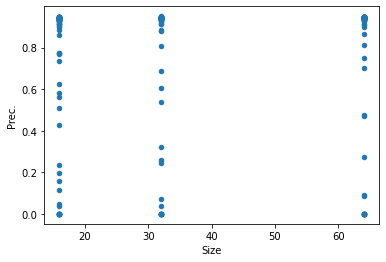

In [22]:
df.plot('Size', 'Prec.', kind='scatter')